<a href="https://colab.research.google.com/github/akhmad-ardi/Computer_Vision/blob/main/Model_Klasifikasi_Rambu_Lalu_Lintas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow

In [2]:
!pip install kagglehub

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPool2D
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("saadhaxxan/germantrafficsigns")

print("Path to dataset files:", path)

100%|██████████| 118M/118M [00:02<00:00, 53.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/saadhaxxan/germantrafficsigns/versions/1


In [5]:


!ls /root/.cache/kagglehub/datasets/saadhaxxan/germantrafficsigns/versions/1

signnames.csv  test.p  train.p	valid.p


In [6]:
## Load the data
training_file = f"{path}/train.p"
testing_file = f"{path}/test.p"

# Open and load the training file
with open(training_file, mode='rb') as f:
    train = pickle.load(f)

# Open and load the testing file
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

print("Data loaded")


Data loaded


In [7]:
## Buat pandas dataframe untuk load data csv
## File csv ini berupa ClassId dan SignName

sign_name_df = pd.read_csv(f'{path}/signnames.csv')
SIGN_NAMES = sign_name_df.SignName.values
sign_name_df.set_index('ClassId', inplace=True)
sign_name_df.head(10)

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)
5,Speed limit (80km/h)
6,End of speed limit (80km/h)
7,Speed limit (100km/h)
8,Speed limit (120km/h)


In [8]:
# Definisikan fitur dan label untuk data training
X, y = train['features'], train['labels']

# Mengubah lists menjadi numpy arrays
data = np.array(X)
labels = np.array(y)
print(data.shape, labels.shape)

# Definisikan fitur dan label untuk data testing
X_test, y_test = test['features'], test['labels']

# Mengubah lists menjadi numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape, y_test.shape)

(34799, 32, 32, 3) (34799,)
(12630, 32, 32, 3) (12630,)


In [9]:
# Split training data into train and val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(31319, 32, 32, 3) (3480, 32, 32, 3) (31319,) (3480,)


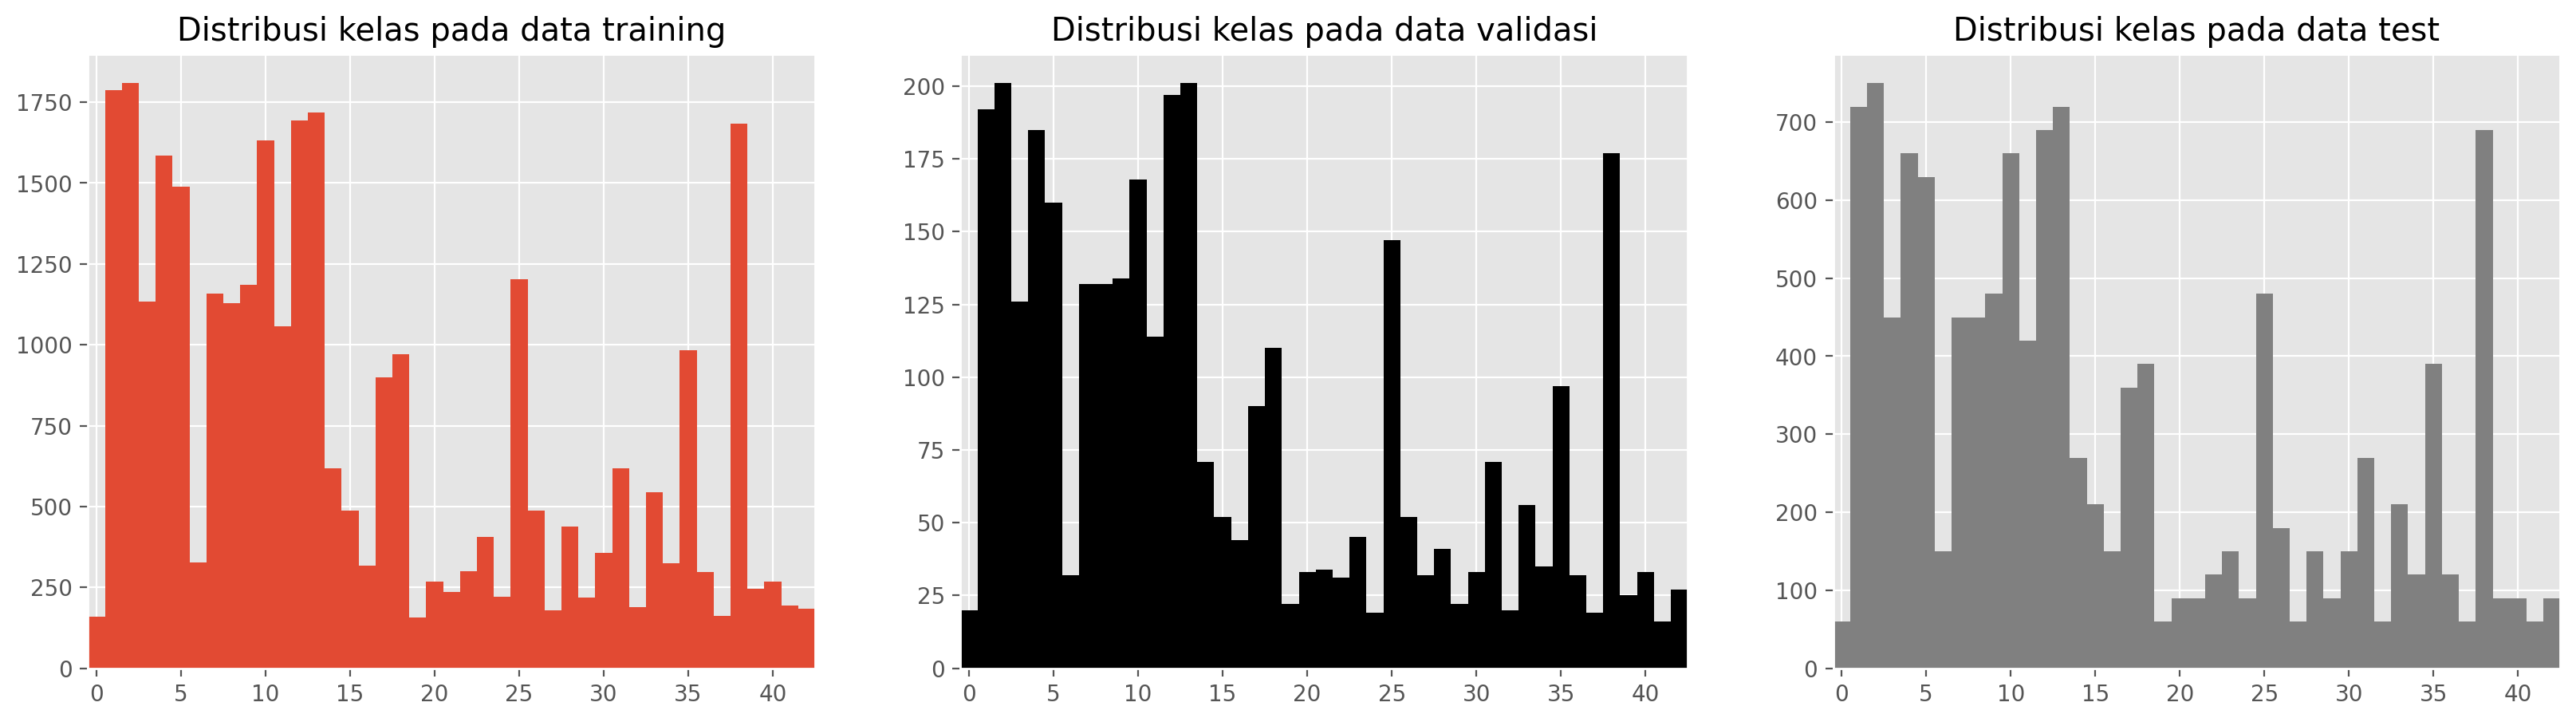

In [10]:
n_labels = np.unique(y_train).size
def hist_data(y_data, title=None, ax=None, **kwargs):
    if not ax :
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.hist(y_data, np.arange(-0.5, n_labels+1.5), stacked=True, **kwargs)
    ax.set_xlim(-0.5, n_labels-0.5)
    if 'label' in kwargs : ax.legend()
    if title : ax.set_title(title)

fig,ax = plt.subplots(1,3, figsize=(20,5))
hist_data(y_train, title='Distribusi kelas pada data training', ax=ax[0])
hist_data(y_val, title='Distribusi kelas pada data validasi', ax=ax[1], color='black')
hist_data(y_test, title='Distribusi kelas pada data test', ax=ax[2], color='grey')

In [11]:
# Konversi label dengan teknik one hot encoding
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

In [12]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.96):
      print("\nAkurasi telah mencapai >96%. Stop training!")
      self.model.stop_training = True
callbacks = myCallback()

In [13]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 3)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D(2,2),
    Dropout(0.25),

    Conv2D(128, (3,3), activation='relu'),
    Conv2D(128, (3,3), activation='relu'),
    MaxPool2D(2,2),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(43, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
epochs = 25
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_val, y_val), callbacks=[callbacks])
model.save("my_model.h5")

Epoch 1/25
979/979 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.3896 - loss: 3.1611 - val_accuracy: 0.9618 - val_loss: 0.1709
Epoch 2/25
979/979 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9049 - loss: 0.3332 - val_accuracy: 0.9799 - val_loss: 0.0899
Epoch 3/25
979/979 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9376 - loss: 0.2272 - val_accuracy: 0.9934 - val_loss: 0.0392
Epoch 4/25
979/979 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9592 - loss: 0.1499 - val_accuracy: 0.9807 - val_loss: 0.0733
Epoch 5/25
979/979 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9574 - loss: 0.1552 - val_accuracy: 0.9805 - val_loss: 0.0737
Epoch 6/25
975/979 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9632 - loss: 0.1426
Akurasi telah mencapai >96%. Stop training!
979/979 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9632 - loss: 0.1426 - val_accuracy: 0.9882 - val_loss: 0.0440


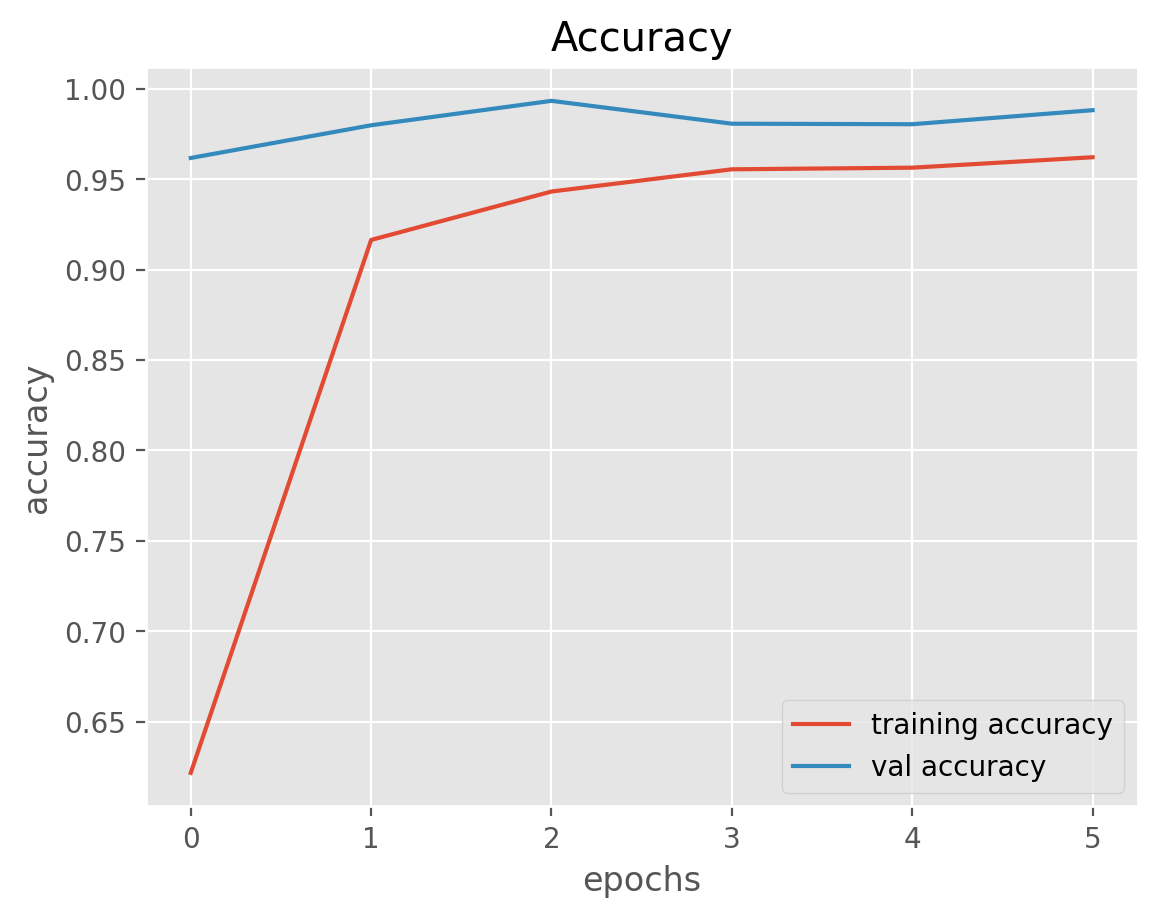

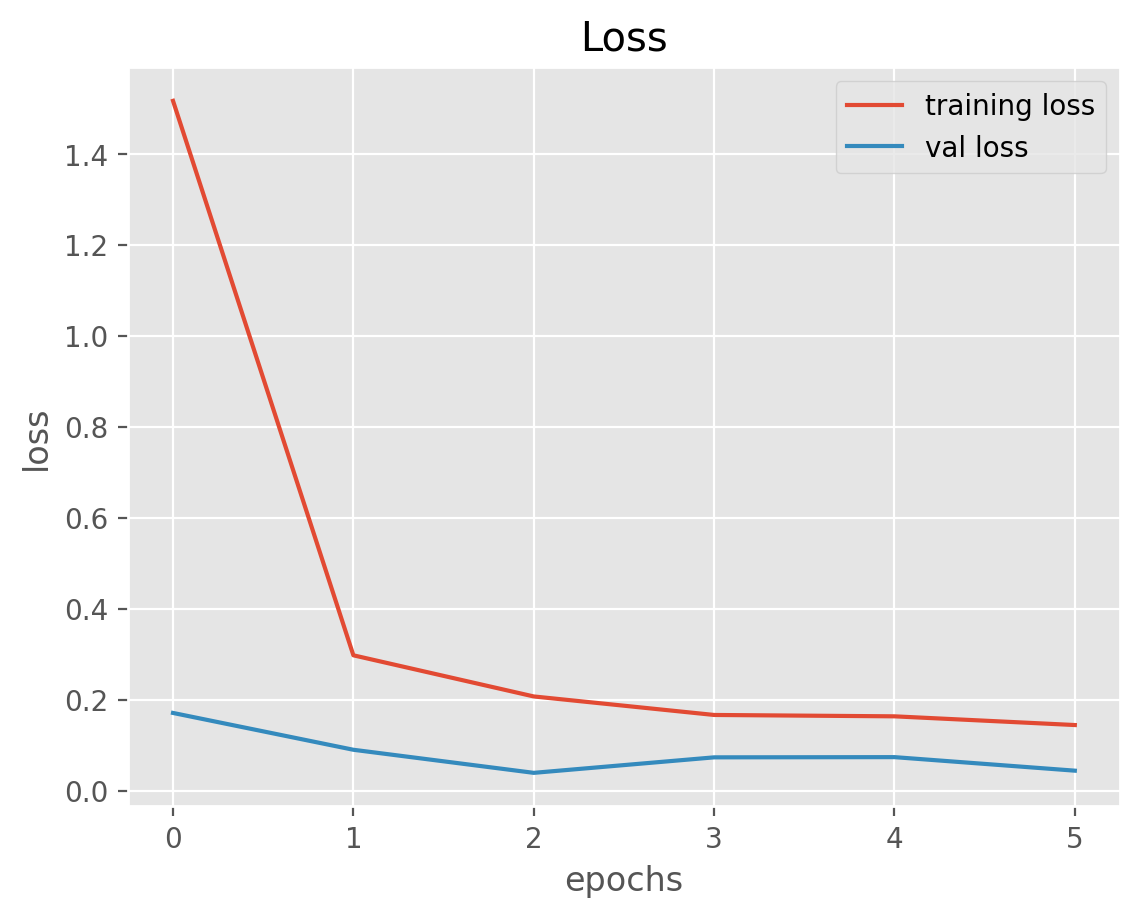

In [16]:
# Plotting graphs for accuracy
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Plotting graphs for loss
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [17]:
# Testing accuracy with the test data
from sklearn.metrics import accuracy_score

pred=np.argmax(model.predict(X_test), axis=-1)
accuracy_score(y_test, pred)

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


0.9618368962787015

In [18]:
# Calculate metrics for classification
from sklearn.metrics import classification_report

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        60
           1       0.91      0.99      0.95       720
           2       0.98      0.99      0.98       750
           3       0.98      0.92      0.95       450
           4       0.99      0.99      0.99       660
           5       0.91      0.96      0.94       630
           6       0.99      0.85      0.92       150
           7       0.97      0.98      0.97       450
           8       0.97      0.96      0.97       450
           9       0.99      0.99      0.99       480
          10       0.99      0.99      0.99       660
          11       0.99      0.93      0.96       420
          12       0.98      0.99      0.98       690
          13       0.99      0.99      0.99       720
          14       0.93      1.00      0.97       270
          15       0.97      1.00      0.98       210
          16       0.99      1.00      0.99       150
          17       1.00    